In [5]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt

# Block on a slope

Try MPPI controller with a simple block on a slope.

*TODO*: add optional friction on the slope

In [31]:
def block_on_slope(block_mass, slope_angle, gravity_accel, desired_state, dt):
    # Apply a force parallel to the slope to achieve a desired position
    # and velocity of the block

    nx, nu = 2, 1

    def terminal_cost(x):
        return np.linalg.norm(desired_state - x)

    def state_cost(x):
        return np.linalg.norm(np.array([[100, 0], [0, 1]]) @ (desired_state - x))

    def control_cost(u, sigma_inv, temp):
        base_controls = u[:nu]
        control_noise = u[nu:]

        return temp * np.dot(base_controls, np.dot(sigma_inv, control_noise))

    def evolve_state(x_u, nx, nu, dt):
        x = x_u[:nx]
        u = x_u[nx:]

        # accel = gravity_accel * np.sin(slope_angle) - (u[0] / block_mass)
        accel = u[0] / block_mass

        evolved_state = np.dot(np.array([[1, dt], [0, 1]]), x) + \
                        np.array([0, accel * dt])

        return evolved_state

    def simulator(x, u):
        return evolve_state(np.hstack((x, u)), nx, nu, dt=dt)

    controller = MPPIController.MPPIController(
        n_rollouts=200,
        horizon_length=20,
        exploration_cov=np.array([[3]]),
        exploration_lambda=0.5,
        nx=nx,
        nu=nu,
        terminal_cost=terminal_cost,
        state_cost=state_cost,
        control_cost=control_cost,
        control_cov=np.array([[1]]),
        evolve_state=evolve_state,
        dt=dt
    )

    return controller, simulator

In [28]:
# Create the block on slope controller

sample_hz = 5
dt = 1 / sample_hz
desired_state = np.array([10, 0])

controller, simulator = block_on_slope(
    block_mass = 5, # kg
    slope_angle = np.radians(30), # radians
    gravity_accel = -9.81, # m / s^2
    desired_state = desired_state,
    dt = dt
)

[MPPI] [Warn] No control range input. Assuming [-inf, inf] on all dimensions.


In [29]:
# Create the control loop to run MPPI

current_state = np.array([0, 0])  # [position, velocity]
simulation_length = 10  # seconds

# Create some lists to hold plotted information
control_seq = []
xs = []

n_steps = int((1 / dt) * simulation_length)

for i in range(0, n_steps):
    next_u = controller.step(current_state)[0]
    control_seq.append(next_u[0])

    current_state = simulator(current_state, next_u)
    xs.append(current_state[0])

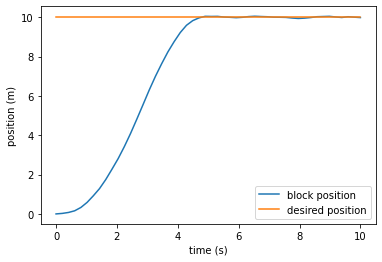

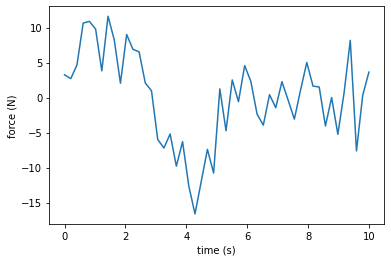

In [30]:
# Plot the results

plt.plot(np.linspace(0, simulation_length, n_steps), xs, label="block position")
plt.plot(np.linspace(0, simulation_length, n_steps), np.repeat(desired_state[0], n_steps), label="desired position")
plt.xlabel("time (s)"); plt.ylabel("position (m)")
plt.legend()
plt.show()

plt.plot(np.linspace(0, simulation_length, n_steps), control_seq, label="control")
plt.xlabel("time (s)"); plt.ylabel("force (N)")
plt.show()